# Importing libraries


In [1]:
import numpy as np
import shapefile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import path
import scipy.interpolate as inter

In [ ]:
# Open shapefile
sf = shapefile.Reader("TikunaAquifer.shp")

# Get points ~ has only one shape!!
shp = sf.shapes()[0]

# Collect points
pts = np.asarray(shp.points)

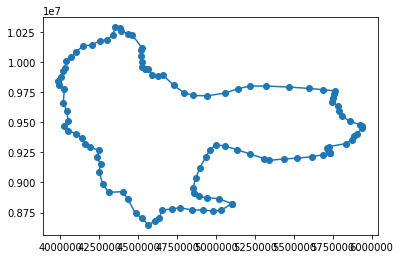

In [3]:
plt.plot(pts[:,0],pts[:,1],'-o')

In [4]:
def CartGrid(x, y, z=None):
    """Build a cartisian grid data (nodes and connections). Returns a tuple with:
    (ndarray nodes coordinate, ndarray cells connectivities)"""

    if z is None:
        nodes = np.array([[i, j, 0.] for j in y for i in x])

        nx = x.size
        ny = y.size
        i, j = np.mgrid[0:nx, 0:ny]
        ij = np.ravel_multi_index(
            [list(i.ravel()), list(j.ravel())], (nx+1, ny+1), order='F')

        cells = np.array([[i, i+1, i+1+nx+1, i+nx+1]
                          for i in ij], dtype='uint64')

    else:
        nodes = np.array([[i, j, k] for k in z for j in y for i in x])

        nx = x.size - 1
        ny = y.size - 1
        nz = z.size - 1

        i, j, k = np.mgrid[0:nx, 0:ny, 0:nz]
        ijk = np.ravel_multi_index(
            [list(i.ravel()), list(j.ravel()), list(
                k.ravel())], (nx + 1, ny + 1, nz + 1),
            order='F')
        cells = np.array([[i, i+1, i+1+(nx+1), i+(nx+1),
                           i+(nx+1)*(ny+1), i+1+(nx+1) *
                           (ny+1), i+1+(nx+1)+(nx+1)*(ny+1),
                           i+(nx+1)+(nx+1)*(ny+1)]
                          for i in ijk], dtype='uint64')

    return (nodes, cells)

In [24]:
dx = 15000 # dx ~ 5km
dy = 15000 # dy ~ 5km
nz = 3
x = np.linspace(shp.bbox[0], shp.bbox[2], int(np.floor((shp.bbox[2]-shp.bbox[0])/dx)))
y = np.linspace(shp.bbox[1], shp.bbox[3], int(np.floor((shp.bbox[3]-shp.bbox[1])/dy)))
z = np.linspace(0,1,nz+1)
(nodes, cells) = CartGrid(x, y, z)

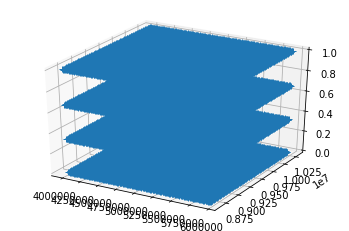

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(nodes[:,0],nodes[:,1],nodes[:,2],'+')

In [25]:
cell_center = np.zeros((cells.shape[0], 3))
print("compute cell centers")
for c in range(cells.shape[0]):
    cell_center[c, :] = np.mean(nodes[cells[c, :], :], axis=0)


compute cell centers


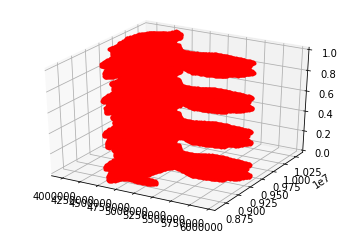

In [30]:
p = path.Path(pts)
msk = p.contains_points(cell_center[:,[0,1]])
cnodes = cells[msk]
vnodes = np.unique(cnodes.reshape(cnodes.size))
idx = np.zeros((int(vnodes.max()+1),))
idx[vnodes] = np.arange(0, vnodes.size)
vert = nodes[vnodes]
hexa = np.reshape(idx[cnodes].ravel(), (cnodes.shape[0],8))

# plot nodes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(vert[:,0],vert[:,1],vert[:,2],'r.')

In [9]:
def find_indexes(b):
    """This function is similar to the 'find' a MATLAB function"""
    return [i for (i, vals) in enumerate(b) if vals]

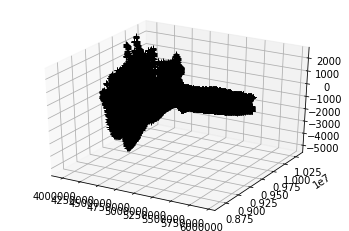

In [33]:
# top horizon
top = vert[:,-1] == 1
D = np.loadtxt('Tikuna_top_horizon.txt', skiprows=1, usecols=[1,2,3])
xt = D[:,0]; xx = [np.min(x), np.max(x)]
yt = D[:,1]; yy = [np.min(y), np.max(y)]
zt = D[:,2]

# base horizon
base = vert[:,-1] == 0
D = np.loadtxt('Tikuna_base_horizon.txt', skiprows=1, usecols=[1,2,3])
xb = D[:,0]; xx = [np.min(x), np.max(x)]
yb = D[:,1]; yy = [np.min(y), np.max(y)]
zb = D[:,2]

# interpolate verticies
zfun = inter.Rbf(xt, yt, zt, function= 'linear',smooth= 100)
vert[top,-1] = zfun(vert[top,0], vert[top,1])

zfun = inter.Rbf(xb, yb, zb, function= 'linear',smooth= 100)
vert[base,-1] = zfun(vert[base,0], vert[base,1])

vmsk = np.zeros((vert.shape[0],), dtype=bool)

# mark horizons (top and base)
horz = np.zeros((vert.shape[0],))
horz[top] = 1; horz[base] = -1
for i in range(vert.shape[0]):
    if vmsk[i]:
        continue
    vmsk[i] = True

    # diff of nodes (same pillar has dx=dy=0)
    dx = np.abs(vert[i, :] - vert[:, ])[:, 0:2]

    # check for pillar
    msk = np.array(find_indexes((dx[:, 0] < 1e-9) & (dx[:, 1] < 1e-9)))
    hh = horz[msk]
    top = np.argmax(hh)
    base = np.argmin(hh)

    if np.abs(vert[msk[0],-1] - vert[msk[-1],-1]) > 1e-9:
        # sort
        z_linspace = np.linspace(vert[msk[0],-1], vert[msk[-1],-1], len(msk))
        vert[msk, -1] = z_linspace
    else:
        # sort
        z_linspace = np.linspace(vert[msk[0],-1] - 5, vert[msk[-1],-1] + 5, len(msk))
        vert[msk, -1] = z_linspace

    if vert[msk[top],-1] < vert[msk[base],-1]:
        vert[msk] = np.flipud(vert[msk])
    vmsk[msk] = True

# plot new verticies
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(vert[:,0],vert[:,1],vert[:,2],'k+')

In [34]:
def write_unv(fname, nodes, cells, mat=None):
    """
    Write the UNV (Universal) file dataset format
    reference in: https://docs.plm.automation.siemens.com/tdoc/nx/12/nx_help#uid:xid1128419:index_advanced:xid1404601:xid1404604
    """

    # consts
    sep = "    -1"
    si, coordsys, vertices, elements = 164, 2420, 2411, 2412

    # settings
    if mat is None:
        mat = np.zeros((cells.shape[0],), dtype=np.int64) + 1

    # write unv file
    print("-- writing file: {}".format(fname))
    with open(fname, "w") as unv:
        # unit system (164)
        unv.write('{}\n'.format(sep))
        unv.write('{:6g}\n'.format(si))  # unv code
        unv.write('{:10d}{:20s}{:10d}\n'.format(1, "SI: Meters (newton)", 2))
        unv.write('{:25.17E}{:25.17E}{:25.17E}\n{:25.17E}\n'.format(
            1, 1, 1, 273.15))
        unv.write('{}\n'.format(sep))

        # coordinate system (2420)
        unv.write('{}\n'.format(sep))
        unv.write('{:6g}\n'.format(coordsys))  # unv code
        unv.write('{:10d}\n'.format(1))  # coordsys label (uid)
        unv.write('{:40s}\n'.format("SMESH_Mesh from Salome Geomechanics"))
        # coordsys label, coordsys type (0: cartesian), coordsys color
        unv.write('{:10d}{:10d}{:10d}\n'.format(1, 0, 0))
        unv.write('{:40s}\n'.format("Global cartesian coord. system"))
        unv.write('{:25.16E}{:25.16E}{:25.16E}\n'.format(1, 0, 0))
        unv.write('{:25.16E}{:25.16E}{:25.16E}\n'.format(0, 1, 0))
        unv.write('{:25.16E}{:25.16E}{:25.16E}\n'.format(0, 0, 1))
        unv.write('{:25.16E}{:25.16E}{:25.16E}\n'.format(0, 0, 0))
        unv.write('{}\n'.format(sep))

        # write nodes coordinates
        unv.write('{}\n'.format(sep))
        unv.write('{:6g}\n'.format(vertices))  # unv code
        for n in range(nodes.shape[0]):
            # node-id, coordinate system label, displ. coord. system, color(11)
            unv.write('{:10d}{:10d}{:10d}{:10d}\n'.format(n + 1, 1, 1, 11))
            unv.write('{:25.16E}{:25.16E}{:25.16E}'.format(
                nodes[n, 0], nodes[n, 1], nodes[n, 2]*50))
            unv.write('\n')
        unv.write('{}\n'.format(sep))

        # write cells connectivities
        unv.write('{}\n'.format(sep))
        unv.write('{:6g}\n'.format(elements))  # unv code
        for c in range(cells.shape[0]):
            # node-id, coordinate system label, displ. coord. system, color(11)
            unv.write('{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}\n'.format(
                c + 1, 115, mat[c], mat[c], mat[c], 8))
            unv.write('{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}'.format(
                cells[c, 0], cells[c, 1], cells[c, 2], cells[c, 3],
                cells[c, 4], cells[c, 5], cells[c, 6], cells[c, 7]))
            unv.write('\n')
        unv.write('{}\n'.format(sep))

        # write cells regions
        unv.write('{}\n'.format(sep))
        unv.write('{:6g}\n'.format(2467))  # unv code
        regions = np.unique(mat)
        for region in regions:
            ind = find_indexes(mat == region)
            unv.write('{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}{:10d}\n'.format(
                region, 0, 0, 0, 0, 0, 0, len(ind)))       
            unv.write('Region_{}\n'.format(region))
            i = 0
            for c in range(len(ind)):
                unv.write('{:10d}{:10d}{:10d}{:10d}'.format( 8, ind[c] + 1, 0, 0))
                i += 1
                if i == 2:
                    i = 0
                    unv.write('\n')
            if i == 1:
                unv.write('\n')
        unv.write('{}\n'.format(sep))

In [35]:
write_unv('tikuna.unv', vert, np.int64(hexa)+1)

-- writing file: tikuna.unv


In [30]:
# Open shapefile
sf = shapefile.Reader("afloramentos_simp.shp")

# Get points ~ has only one shape!!
shp = sf.shapes()[6]

# Collect points
pts2 = np.asarray(shp.points)

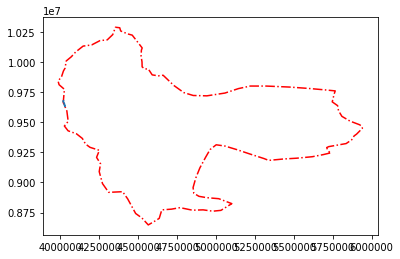

In [31]:
plt.plot(pts[:,0],pts[:,1],'-.r',pts2[:,0],pts2[:,1],'-.')